In [17]:
import kaolin
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
input_dims=2
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/multiple_sites/"


Using device:  NVIDIA GeForce RTX 3050 Laptop GPU


In [23]:
num_centroids = 64*64
site_fp = f'sites_{num_centroids}_{input_dims}.pt'

if os.path.exists(site_fp):
    sites = torch.load(site_fp)
else:
    sites = su.createCVTgrid(num_centroids=num_centroids, dimensionality=input_dims)
    #save the initial sites torch tensor
    torch.save(sites, site_fp)

torch.Size([4096, 2]) torch.float64


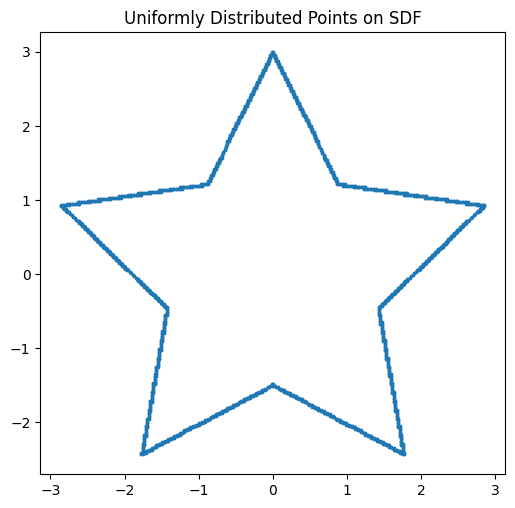

Points shape:  torch.Size([1286, 2])


In [24]:
# Generate points
#true_points = generate_rectangle_points(num_points=400, width=1.0, height=1.0, scale=6.0)

sdf_function = sdf.star_sdf

true_points = sdf.generate_sdf_points(grid_size=1000, width=20.0, height=20.0, sdf_function=sdf_function, threshold=13e-3)

if sdf_function == sdf.bunny_sdf:
    #shift points to the center
    true_points = true_points - torch.tensor([2,2])
    true_points = true_points * 1.5

if sdf_function == sdf.moon_sdf:
    true_points = true_points + torch.tensor([2,0])
    

# Plot points
plt.figure(figsize=(6, 6))
plt.axes().set_aspect('equal')
plt.scatter(true_points[:, 0].cpu(), true_points[:, 1].cpu(), s=3)
plt.title("Uniformly Distributed Points on SDF")

plt.show()

print("Points shape: ", true_points.shape)

loaded model


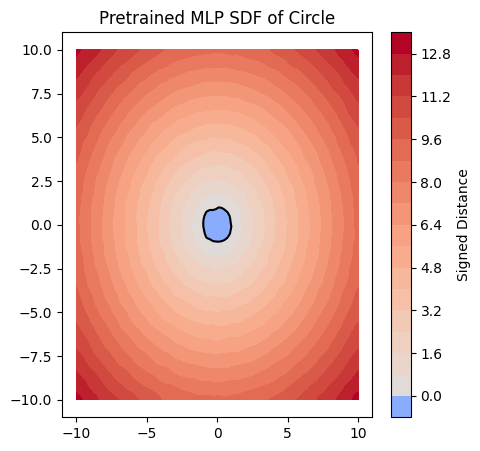

In [20]:
import matplotlib
import os

model = mlp.Decoder(multires=multires, input_dims=input_dims).to(device)
model_path = 'models_resources/pretrained_circle_small.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_circle(3000, radius=1.0)
    torch.save(model.state_dict(),model_path)

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")
plt.title("Pretrained MLP SDF of Circle")
plt.xlim(-11, 11)
plt.ylim(-11, 11)

plt.show()


In [ ]:
cvt_loss_values = []
min_distance_loss_values = []
edge_smoothing_loss_values = []
chamfer_distance_loss_values = []
eikonal_loss_values = []
domain_restriction_loss_values = []
zero_true_points_loss_values = []
loss_values = []

def autograd(sites, model, max_iter=100, stop_train_threshold=1e-6, upsampling=0, lambda_weights = [0.1,1.0,0.1,0.1,1.0,1.0,0.1]):
    optimizer = torch.optim.Adam([
    {'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
    {'params': [sites], 'lr': lr_sites}
], betas=(0.5, 0.999))

    prev_loss = float("inf")
    best_loss = float("inf")
    upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    lambda_sdf = lambda_weights[1]
    lambda_min_distance = lambda_weights[2]
    lambda_laplace = lambda_weights[3]
    lamda_chamfer = lambda_weights[4]
    lamda_eikonal = lambda_weights[5]
    lambda_domain_restriction = lambda_weights[6]
    lambda_true_points = lambda_weights[7]
    
    
    
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    gif_frames = []  # List to store individual frames for GIF
    gif_fn = f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif'
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a single figure
    
    while epoch <= max_iter:
        optimizer.zero_grad()
        
        vertices_to_compute, bisectors_to_compute = su.compute_zero_crossing_vertices(sites, model)
        #vertices = su.compute_all_vertices(sites, vertices_to_compute)
        vertices = su.compute_vertices_2d_vectorized(sites, vertices_to_compute)
        
        #bisectors = su.compute_all_bisectors(sites, bisectors_to_compute)
        bisectors = su.compute_all_bisectors_vectorized(sites, bisectors_to_compute)
        
    
        
        #combine vertices and bisectors to one tensor for chamfer
        points = torch.cat((vertices, bisectors), 0)
        #points = bisectors        
        #points = vertices        
        
        # Compute losses       
        cvt_loss = lf.compute_cvt_loss(sites)
        #min_distance_loss = min_distance_regularization_for_op_sites(edges,sites)
        min_distance_loss = lf.sdf_weighted_min_distance_loss(model, sites)
        #edge_smoothing_loss = compute_edge_smoothing_loss(edges, sites, model)
        chamfer_loss = lf.chamfer_distance(true_points, points)
        eikonal_loss = lf.eikonal(model, input_dimensions=input_dims)

        domain_restriction_loss = lf.domain_restriction(true_points, model)
        
        sdf_values_true_points = model(true_points)[:,0]
        zero_true_points_loss_L2 = torch.mean(sdf_values_true_points**2)
        zero_true_points_loss_L1 = torch.mean(torch.abs(model(true_points)[:, 0]))
        lambda_1, lambda_2 = 0 , 0.99  # Adjust weights as needed
        zero_true_points_loss = lambda_1 * zero_true_points_loss_L1 + lambda_2 * zero_true_points_loss_L2

               
        # Track raw losses (unweighted)
        cvt_loss_values.append(cvt_loss.item())
        min_distance_loss_values.append(min_distance_loss.item())
        #edge_smoothing_loss_values.append(edge_smoothing_loss.item())
        chamfer_distance_loss_values.append(chamfer_loss.item())
        eikonal_loss_values.append(eikonal_loss.item())
        domain_restriction_loss_values.append(domain_restriction_loss.item())
        zero_true_points_loss_values.append(zero_true_points_loss.item())
  
        loss = (
            lambda_cvt * cvt_loss +
            lambda_min_distance * min_distance_loss + 
            #lambda_laplace * edge_smoothing_loss +
            lamda_chamfer * chamfer_loss +
            lamda_eikonal * eikonal_loss +
            lambda_domain_restriction * domain_restriction_loss +
            lambda_true_points * zero_true_points_loss
        )
        loss_values.append(loss.item())
        print(f"Epoch {epoch}: loss = {loss.item()}")
                
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            if upsampled > 0:
                print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            #break
        
        prev_loss = loss.item() 
        
        #TODO change how to do upsampling
        #if epoch>100 and epoch%100 == 1 and upsampled < 2:
        if epoch>100 and (epoch // 100) == upsampled+1 and loss.item() < 0.5 and upsampled < upsampling:
            print("sites length: ",len(sites))
            
            new_sites = su.upsampling_inside(best_sites, model)
            #new_sites = su.adaptive_density_upsampling(best_sites, model)
            print(new_sites)
            sites = su.add_upsampled_sites(best_sites, new_sites)
            sites = sites.detach().requires_grad_(True)
            print("upsampled sites length: ",len(sites))
            
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            
            optimizer = torch.optim.Adam([{'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
                                          {'params': [sites], 'lr': lr_sites}])
            upsampled += 1.0

        # Plot Voronoi diagram
        sites_np = sites.detach().cpu().numpy()
        voronoi_initial = Voronoi(sites_np)
        ax.clear()  # Clear the current plot
        voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
        xx, yy, sdf_values = sdf.plot_sdf(ax, model)

        #convert sdf to numpy
        sdf_values = sdf_values.cpu().detach().numpy()

        norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

        # Plot the SDF with the centered colormap
        contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

        ax.scatter(true_points[:,0].cpu(), true_points[:,1].cpu(), color='green', s=1)

        #plot vertices
        ax.scatter(vertices[:,0].detach().cpu().numpy(), vertices[:,1].detach().cpu().numpy(), color='red', s=30)
        ax.scatter(bisectors[:,0].detach().cpu().numpy(), bisectors[:,1].detach().cpu().numpy(), color='yellow', s=30)
      
        ax.set_title(f"Epoch {epoch} - Loss: {loss:.4f}")
        
        # Save the current figure to an in-memory buffer
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Append the buffer content as an image frame
        gif_frames.append(Image.open(buf))
                        
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
            # Save the GIF
            gif_frames[0].save(
                f'{destination}{max_iter}_{epoch}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif',
                save_all=True,            
                append_images=gif_frames[1:],
                duration=100,  # Duration in ms between frames
                loop=0
            )
            print("GIF saved as ",f'{destination}{max_iter}_{epoch}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif',
)
                    
        epoch += 1
            
    # Save the GIF
    gif_frames[0].save(
        gif_fn,
        save_all=True,
        append_images=gif_frames[1:],
        duration=100,  # Duration in ms between frames
        loop=0
    )
    print("GIF saved as ", gif_fn)
            
        
    return best_sites

Epoch 0: loss = 47.64506671665039
Epoch 0: loss = 47.64506671665039
Best Epoch 0: Best loss = 47.64506671665039
GIF saved as  ./images/autograd/multiple_sites/500_0_cvt_0.2_sdf_0_min_distance_0.1_laplace_0_chamfer_1.003211211121121.gif
Epoch 1: loss = 38.88998781158687
Epoch 2: loss = 13.04512961596313
Epoch 3: loss = 12.344881536261164
Epoch 4: loss = 1.6150150387386033
Epoch 5: loss = 12.254684234112764
Epoch 6: loss = 8.591295982296229
Epoch 7: loss = 1886.0253593460538
Epoch 8: loss = 4.994273259619105
Epoch 9: loss = 6.0401830436660875
Epoch 10: loss = 173.55692812518348
Epoch 11: loss = 0.7564600699351895
Epoch 12: loss = 0.7137750413756037
Epoch 13: loss = 0.6620403728193531
Epoch 14: loss = 1.039473256595426
Epoch 15: loss = 0.564848060992827
Epoch 16: loss = 0.6111389861529318
Epoch 17: loss = 0.6641149630965695
Epoch 18: loss = 0.5173269883983038
Epoch 19: loss = 1.665668367708923
Epoch 20: loss = 2.919319007551545
Epoch 21: loss = 0.7437488735661499
Epoch 22: loss = 0.589331

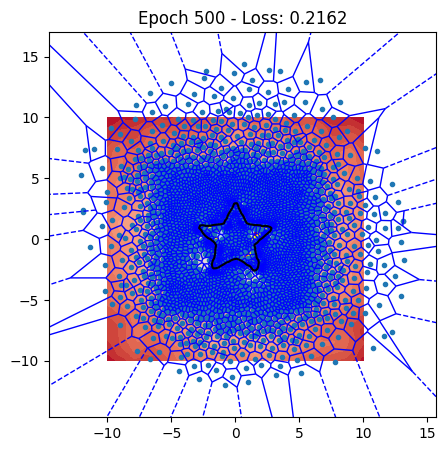

In [25]:
lambda_weights = [0.2,0,0.1,0,1.0032112111211212111111111111,0.1,0,2]

lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lamda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
lambda_true_points = lambda_weights[7]

max_iter = 500

site_file_path = f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}_eikonal_{lambda_eikonal}.npy'
#check if optimized sites file exists
if os.path.exists(site_file_path):
    #import sites
    print("Importing sites")
    sites = np.load(site_file_path)
    sites = torch.from_numpy(sites).to(device).requires_grad_(True)
else:
    sites = autograd(sites, model, max_iter=max_iter, upsampling=0, lambda_weights=lambda_weights)
    sites_np = sites.detach().cpu().numpy()
    np.save(site_file_path, sites_np)
    

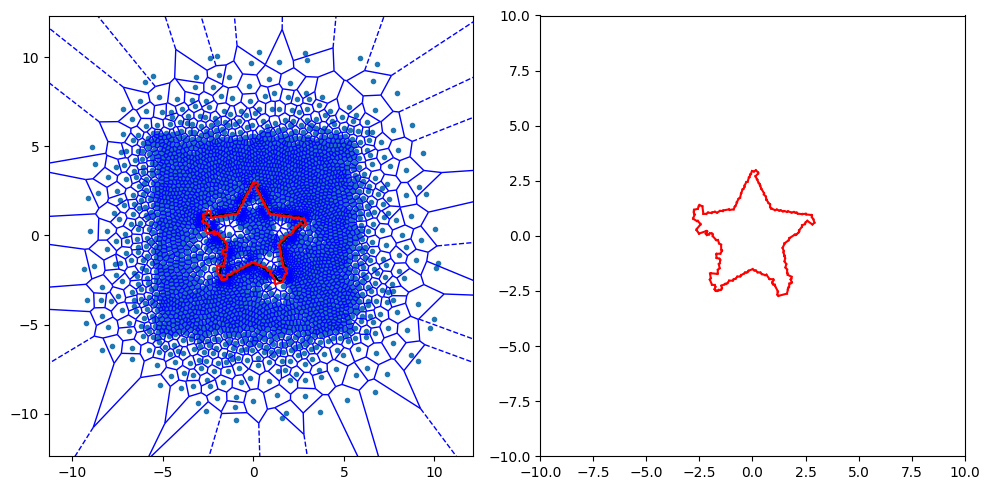

In [26]:
edges = su.get_sites_zero_crossing_edges(sites, model)

sites_np = sites.detach().cpu().numpy()
# Compute Voronoi diagram
vor = Voronoi(sites_np)

# Create two subplots: one with Voronoi diagram and one without
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot with Voronoi diagram
ax1 = axs[0]
voronoi_plot_2d(vor, ax=ax1, show_vertices=False, line_colors='blue')
sdf.plot_sdf(ax1, model)

#ax1.set_title("With Voronoi Diagram")

# Plot edges
for vertex1, vertex2 in edges:
    v1 = vor.vertices[vertex1]
    v2 = vor.vertices[vertex2]
    ax1.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

#ax1.legend(['Zero-crossing edges'], loc='upper right')
# Plot without Voronoi diagram
ax2 = axs[1]
#plot_sdf(ax2, model)
#ax2.set_title("Without Voronoi Diagram")
#plt.triplot(*zip(*sites_np), 'o', markersize=3, color='blue')
# Plot edges
for vertex1, vertex2 in edges:
    v1 = vor.vertices[vertex1]
    v2 = vor.vertices[vertex2]
    ax2.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')
#ax2.legend(['Zero-crossing edges'], loc='upper right')
# plt.plot([], [], 'r-', label='sites zero-crossing edge')
# limit of the plot
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.tight_layout()
plt.savefig(f'{destination}edge_sdf_crossing.png')

plt.show()    

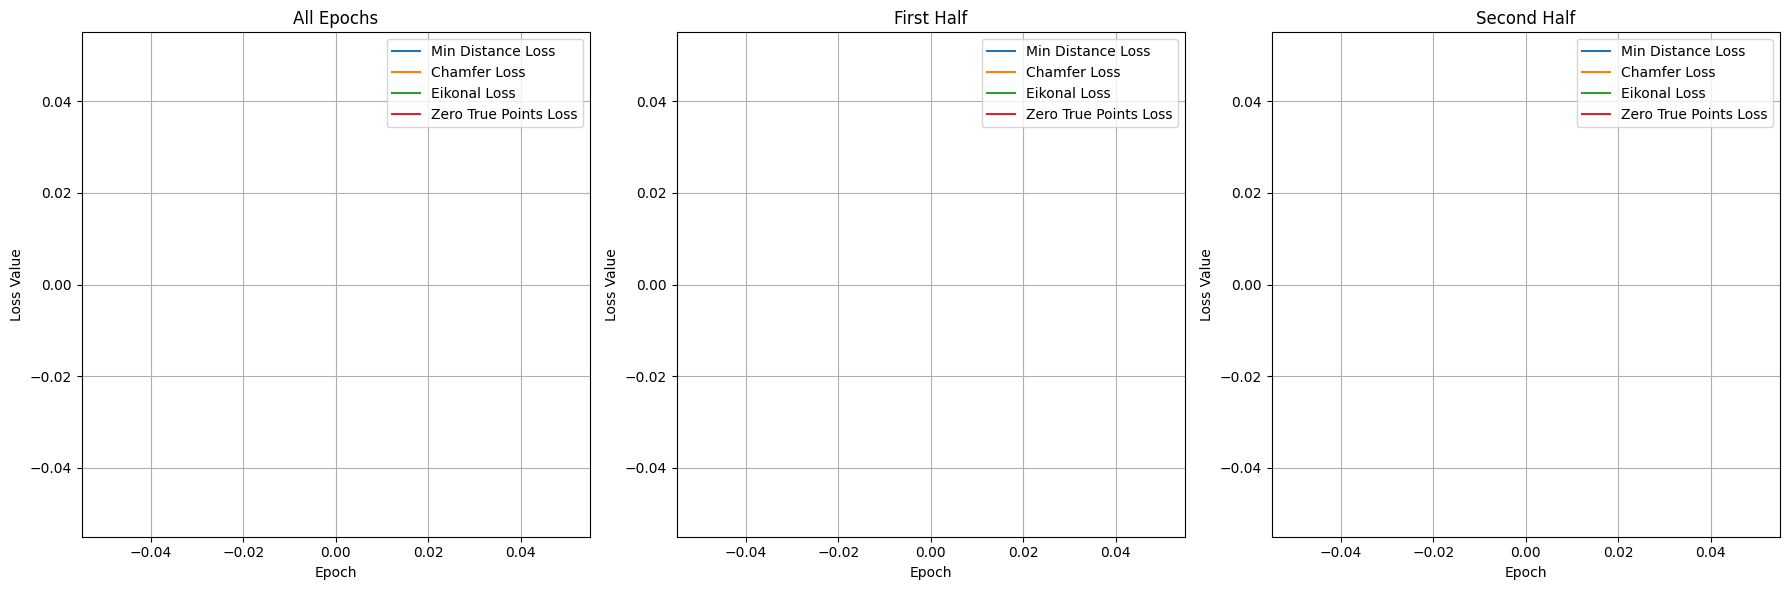

In [ ]:
# Define the total number of epochs and split into halves
total_epochs = len(chamfer_distance_loss_values)
half_epoch = total_epochs // 2

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot all epochs (x-axis from 0 to 80)
#axes[0].plot(range(total_epochs), sdf_loss_values, label="SDF Loss")
#axes[0].plot(range(total_epochs), cvt_loss_values, label="CVT Loss")
axes[0].plot(range(total_epochs), min_distance_loss_values, label="Min Distance Loss")
#axes[0].plot(range(total_epochs), edge_smoothing_loss_values, label="Edge Smoothing Loss")
axes[0].plot(range(total_epochs), chamfer_distance_loss_values, label="Chamfer Loss")
axes[0].plot(range(total_epochs), eikonal_loss_values, label="Eikonal Loss")
#axes[0].plot(range(total_epochs), domain_restriction_loss_values, label="Domain Restriction Loss")
axes[0].plot(range(total_epochs), zero_true_points_loss_values, label="Zero True Points Loss")

#axes[0].set_xlim(0, 80)  # Set x-axis range from 0 to 80
axes[0].set_title("All Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss Value")
axes[0].legend()
axes[0].grid(True)


# Plot first half 
#axes[1].plot(range(half_epoch), sdf_loss_values[:half_epoch], label="SDF Loss")
#axes[1].plot(range(half_epoch), cvt_loss_values[:half_epoch], label="CVT Loss")
axes[1].plot(range(half_epoch), min_distance_loss_values[:half_epoch], label="Min Distance Loss")
#axes[1].plot(range(half_epoch), edge_smoothing_loss_values[:half_epoch], label="Edge Smoothing Loss")
axes[1].plot(range(half_epoch), chamfer_distance_loss_values[:half_epoch], label="Chamfer Loss")
axes[1].plot(range(half_epoch), eikonal_loss_values[:half_epoch], label="Eikonal Loss")
#axes[1].plot(range(half_epoch), domain_restriction_loss_values[:half_epoch], label="Domain Restriction Loss")
axes[1].plot(range(half_epoch), zero_true_points_loss_values[:half_epoch], label="Zero True Points Loss")

axes[1].set_title("First Half")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Value")
axes[1].legend()
axes[1].grid(True)

# Plot second half 
#axes[2].plot(range(half_epoch, total_epochs), sdf_loss_values[half_epoch:], label="SDF Loss")
#axes[2].plot(range(half_epoch, total_epochs), cvt_loss_values[half_epoch:], label="CVT Loss")
axes[2].plot(range(half_epoch, total_epochs), min_distance_loss_values[half_epoch:], label="Min Distance Loss")
#axes[2].plot(range(half_epoch, total_epochs), edge_smoothing_loss_values[half_epoch:], label="Edge Smoothing Loss")
axes[2].plot(range(half_epoch, total_epochs), chamfer_distance_loss_values[half_epoch:], label="Chamfer Loss")
axes[2].plot(range(half_epoch, total_epochs), eikonal_loss_values[half_epoch:], label="Eikonal Loss")
#axes[2].plot(range(half_epoch, total_epochs), domain_restriction_loss_values[half_epoch:], label="Domain Restriction Loss")
axes[2].plot(range(half_epoch, total_epochs), zero_true_points_loss_values[half_epoch:], label="Zero True Points Loss")

axes[2].set_title("Second Half")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss Value")
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


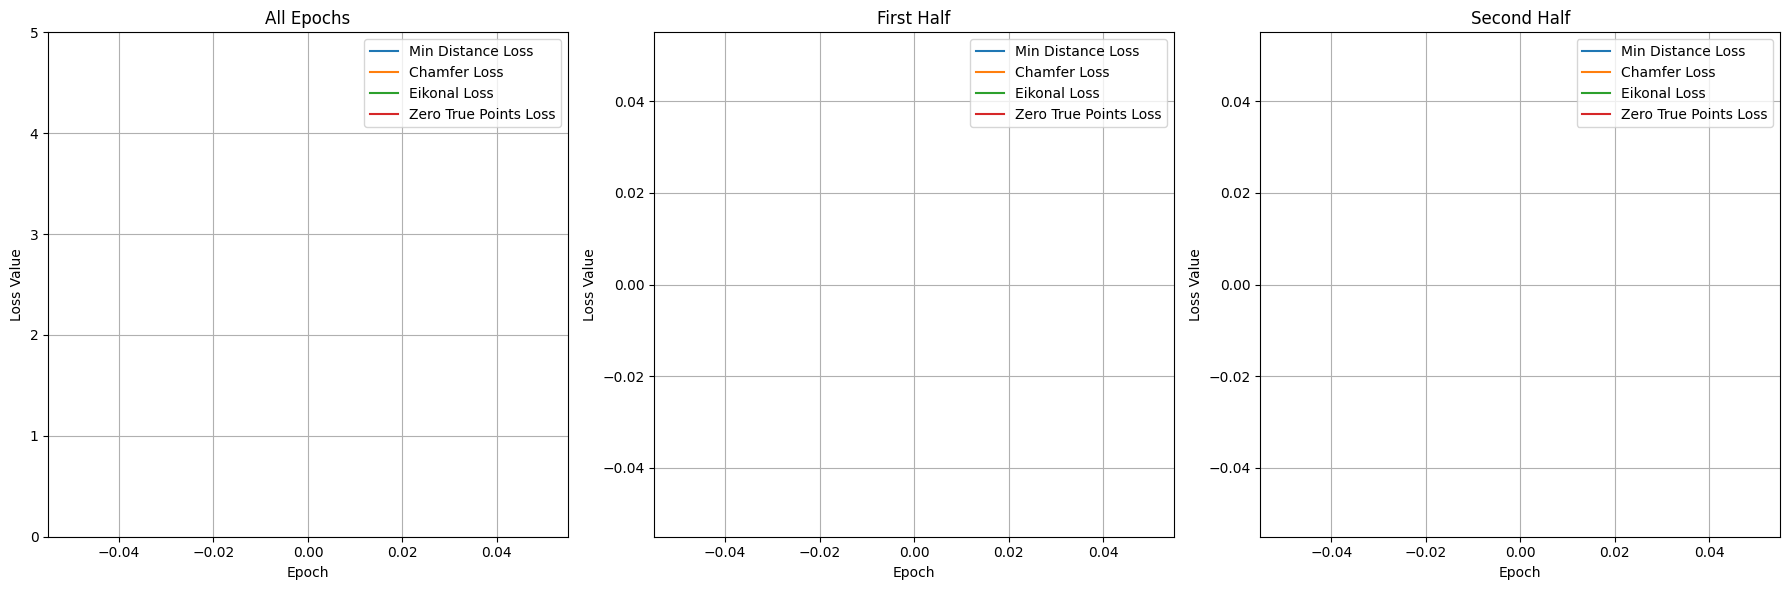

In [ ]:
lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lambda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
    
# Define the total number of epochs and split into halves
total_epochs = len(chamfer_distance_loss_values)
half_epoch = total_epochs // 2

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot all epochs (x-axis from 0 to 80)
#axes[0].plot(range(total_epochs), [x*lambda_sdf for x in sdf_loss_values], label="SDF Loss")
#axes[0].plot(range(total_epochs), [x*lambda_cvt for x in cvt_loss_values], label="CVT Loss")
axes[0].plot(range(total_epochs), [x*lambda_min_distance for x in min_distance_loss_values], label="Min Distance Loss")
#axes[0].plot(range(total_epochs), [x*lambda_laplace for x in edge_smoothing_loss_values], label="Edge Smoothing Loss")
axes[0].plot(range(total_epochs), [x*lambda_chamfer for x in chamfer_distance_loss_values], label="Chamfer Loss")
axes[0].plot(range(total_epochs), [x*lambda_eikonal for x in eikonal_loss_values], label="Eikonal Loss")
#axes[0].plot(range(total_epochs), [x*lambda_domain_restriction for x in domain_restriction_loss_values], label="Domain Restriction Loss")
axes[0].plot(range(total_epochs), [x*lambda_true_points for x in zero_true_points_loss_values], label="Zero True Points Loss")

#axes[0].set_xlim(0, 80)  # Set x-axis range from 0 to 80
axes[0].set_ylim(0, 5)

axes[0].set_title("All Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss Value")
axes[0].legend()
axes[0].grid(True)


# Plot first half 
#axes[1].plot(range(half_epoch), [x*lambda_sdf for x in sdf_loss_values[:half_epoch]], label="SDF Loss")
#axes[1].plot(range(half_epoch), [x*lambda_cvt for x in cvt_loss_values[:half_epoch]], label="CVT Loss")
axes[1].plot(range(half_epoch), [x*lambda_min_distance for x in min_distance_loss_values[:half_epoch]], label="Min Distance Loss")
#axes[1].plot(range(half_epoch), [x*lambda_laplace for x in edge_smoothing_loss_values[:half_epoch]], label="Edge Smoothing Loss")
axes[1].plot(range(half_epoch), [x*lambda_chamfer for x in chamfer_distance_loss_values[:half_epoch]], label="Chamfer Loss")
axes[1].plot(range(half_epoch), [x*lambda_eikonal for x in eikonal_loss_values[:half_epoch]], label="Eikonal Loss")
#axes[1].plot(range(half_epoch), [x*lambda_domain_restriction for x in domain_restriction_loss_values[:half_epoch]], label="Domain Restriction Loss")
axes[1].plot(range(half_epoch), [x*lambda_true_points for x in zero_true_points_loss_values[:half_epoch]], label="Zero True Points Loss")

axes[1].set_title("First Half")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Value")
axes[1].legend()
axes[1].grid(True)

# Plot second half 
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_sdf for x in sdf_loss_values[half_epoch:]], label="SDF Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_cvt for x in cvt_loss_values[half_epoch:]], label="CVT Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_min_distance for x in min_distance_loss_values[half_epoch:]], label="Min Distance Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_laplace for x in edge_smoothing_loss_values[half_epoch:]], label="Edge Smoothing Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_chamfer for x in chamfer_distance_loss_values[half_epoch:]], label="Chamfer Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_eikonal for x in eikonal_loss_values[half_epoch:]], label="Eikonal Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_domain_restriction for x in domain_restriction_loss_values[half_epoch:]], label="Domain Restriction Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_true_points for x in zero_true_points_loss_values[half_epoch:]], label="Zero True Points Loss")

axes[2].set_title("Second Half")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss Value")
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
#retrain limit

# Show the plots
plt.show()


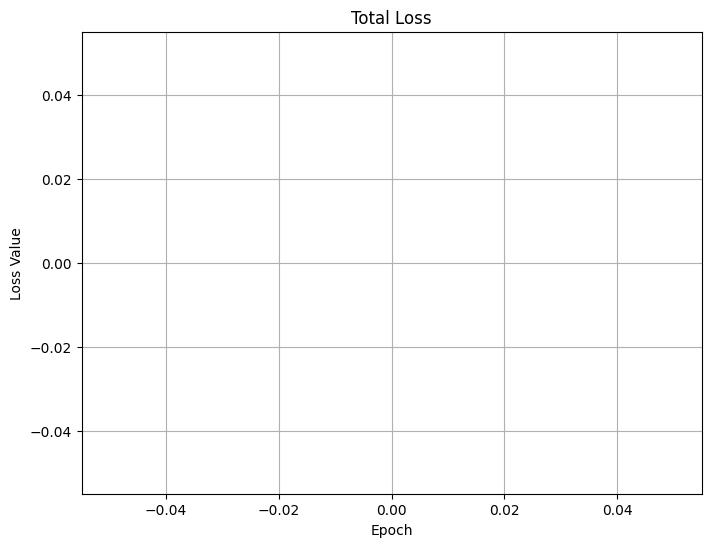

In [ ]:
# Plot the final loss
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_values)), loss_values)
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.grid(True)
plt.show()
